## Settings

In [1]:
import numpy as np # linear algebra
from tqdm import tqdm_notebook
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import pdb

In [2]:
# !pip install transformers

In [3]:
import plotly.graph_objs as go
from matplotlib import pyplot as plt
import plotly.offline as py
import regex as re
from bs4 import BeautifulSoup
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import word_tokenize
from gensim.models import word2vec

In [4]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/train_ami/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [7]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

This notebook approach is derived and inspired from http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

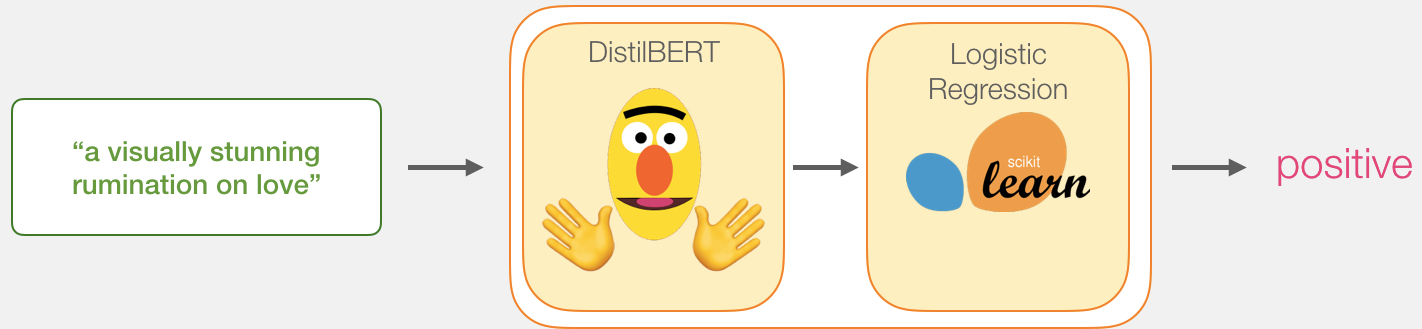

Source: http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

In [8]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/sample_submission.csv")

## Preprocessing

### functions

#### Cleaning

In [ ]:
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))


def clean_text(x):
    x = str(x).replace("\n","")
    
    stops  = set(list(STOPWORDS)+add_stopwords)
    text = [w for w in word_tokenize(x) if w not in stops]    
    text = " ".join(text)
    
    return text


def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x


def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


def replace_typical_misspell(text):
    mispellings, mispellings_re = _get_mispell(mispell_dict)

    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)


def unslang(text):
    """Converts text like "OMG" into "Oh my God"
    """
    text = [slang_abbrev_dict[w.upper()] if w.upper() in slang_abbrev_dict.keys() else w for w in word_tokenize(text)]    
    return " ".join(text)
    

# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_html(text):
    return BeautifulSoup(text, "lxml").text


def clean_data(df, col):
        df[col] = df[col].apply(lambda x: clean_numbers(x))
        df[col] = df[col].apply(lambda x: remove_urls(x))
        df[col] = df[col].apply(lambda x: remove_html(x))
        df[col] = df[col].apply(lambda text: remove_punctuation(text))
        df[col] = df[col].apply(lambda x: clean_text(x.lower()))
        df[col] = df[col].apply(lambda x: replace_typical_misspell(x))
        df[col] = df[col].apply(lambda x: unslang(x))
        df[col] = df[col].apply(lambda x: remove_emoji(x))
        return df

#### embedding

In [9]:
def get_embedding(df,col):
    
    corpus = create_corpus(df,col)
    w2v_model = word2vec.Word2Vec([corpus], size=50, window=10, min_count=1, workers=4)
    embedding_dict={}
    for word in corpus:
        embedding_dict[word] = w2v_model.wv[word]

    num_words=len(corpus)
    embedding_matrix=np.zeros((num_words,50))

    for i,word in tqdm_notebook(enumerate(df[col].unique())):
        if i > num_words:
            continue
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec
    return embedding_matrix

def create_corpus(df,col):
    corpus=[]
    for keyword in tqdm_notebook(df[col].unique()):
        keyword=keyword.lower()
        corpus.append(keyword)
    return corpus

### data understanding

In [ ]:
train.head()

In [ ]:
# lets understand the target distribution
target_cnt=train.target.value_counts()

labels = (np.array(target_cnt.index))
sizes = (np.array((target_cnt / target_cnt.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=10),
    width=300,
    height=300,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

### Data cleaning 

In [10]:
# fill NaN with empty string
train['keyword'] = train.keyword.fillna(value='None')
train['location'] = train.location.fillna(value='None')

test['keyword'] = test.keyword.fillna(value='None')
test['location'] = test.location.fillna(value='None')

In [11]:
PUNCT_TO_REMOVE = string.punctuation
add_stopwords = [
    "a", "about", "above", "after", "again", "against", "ain", "all", "am",
    "an", "and", "any", "are", "aren", "aren't", "as", "at", "be", "because",
    "been", "before", "being", "below", "between", "both", "but", "by", "can",
    "couldn", "couldn't", "d", "did", "didn", "didn't", "do", "does", "doesn",
    "doesn't", "doing", "don", "don't", "down", "during", "each", "few", "for",
    "from", "further", "had", "hadn", "hadn't", "has", "hasn", "hasn't", "have",
    "haven", "haven't", "having", "he", "her", "here", "hers", "herself", "him",
    "himself", "his", "how", "i", "if", "in", "into", "is", "isn", "isn't",
    "it", "it's", "its", "itself", "just", "ll", "m", "ma", "me", "mightn",
    "mightn't", "more", "most", "mustn", "mustn't", "my", "myself", "needn",
    "needn't", "no", "nor", "not", "now", "o", "of", "off", "on", "once",
    "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own",
    "re", "s", "same", "shan", "shan't", "she", "she's", "should", "should've",
    "shouldn", "shouldn't", "so", "some", "such", "t", "than", "that",
    "that'll", "the", "their", "theirs", "them", "themselves", "then", "there",
    "these", "they", "this", "those", "through", "to", "too", "under", "until",
    "up", "ve", "very", "was", "wasn", "wasn't", "we", "were", "weren",
    "weren't", "what", "when", "where", "which", "while", "who", "whom", "why",
    "will", "with", "won", "won't", "wouldn", "wouldn't", "y", "you", "you'd",
    "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves",
    "could", "he'd", "he'll", "he's", "here's", "how's", "i'd", "i'll", "i'm",
    "i've", "let's", "ought", "she'd", "she'll", "that's", "there's", "they'd",
    "they'll", "they're", "they've", "we'd", "we'll", "we're", "we've",
    "what's", "when's", "where's", "who's", "why's", "would", "able", "abst",
    "accordance", "according", "accordingly", "across", "act", "actually",
    "added", "adj", "affected", "affecting", "affects", "afterwards", "ah",
    "almost", "alone", "along", "already", "also", "although", "always",
    "among", "amongst", "announce", "another", "anybody", "anyhow", "anymore",
    "anyone", "anything", "anyway", "anyways", "anywhere", "apparently",
    "approximately", "arent", "arise", "around", "aside", "ask", "asking",
    "auth", "available", "away", "awfully", "b", "back", "became", "become",
    "becomes", "becoming", "beforehand", "begin", "beginning", "beginnings",
    "begins", "behind", "believe", "beside", "besides", "beyond", "biol",
    "brief", "briefly", "c", "ca", "came", "cannot", "can't", "cause", "causes",
    "certain", "certainly", "co", "com", "come", "comes", "contain",
    "containing", "contains", "couldnt", "date", "different", "done",
    "downwards", "due", "e", "ed", "edu", "effect", "eg", "eight", "eighty",
    "either", "else", "elsewhere", "end", "ending", "enough", "especially",
    "et", "etc", "even", "ever", "every", "everybody", "everyone", "everything",
    "everywhere", "ex", "except", "f", "far", "ff", "fifth", "first", "five",
    "fix", "followed", "following", "follows", "former", "formerly", "forth",
    "found", "four", "furthermore", "g", "gave", "get", "gets", "getting",
    "give", "given", "gives", "giving", "go", "goes", "gone", "got", "gotten",
    "h", "happens", "hardly", "hed", "hence", "hereafter", "hereby", "herein",
    "heres", "hereupon", "hes", "hi", "hid", "hither", "home", "howbeit",
    "however", "hundred", "id", "ie", "im", "immediate", "immediately",
    "importance", "important", "inc", "indeed", "index", "information",
    "instead", "invention", "inward", "itd", "it'll", "j", "k", "keep", "keeps",
    "kept", "kg", "km", "know", "known", "knows", "l", "largely", "last",
    "lately", "later", "latter", "latterly", "least", "less", "lest", "let",
    "lets", "like", "liked", "likely", "line", "little", "'ll", "look",
    "looking", "looks", "ltd", "made", "mainly", "make", "makes", "many", "may",
    "maybe", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might",
    "million", "miss", "ml", "moreover", "mostly", "mr", "mrs", "much", "mug",
    "must", "n", "na", "name", "namely", "nay", "nd", "near", "nearly",
    "necessarily", "necessary", "need", "needs", "neither", "never",
    "nevertheless", "new", "next", "nine", "ninety", "nobody", "non", "none",
    "nonetheless", "noone", "normally", "nos", "noted", "nothing", "nowhere",
    "obtain", "obtained", "obviously", "often", "oh", "ok", "okay", "old",
    "omitted", "one", "ones", "onto", "ord", "others", "otherwise", "outside",
    "overall", "owing", "p", "page", "pages", "part", "particular",
    "particularly", "past", "per", "perhaps", "placed", "please", "plus",
    "poorly", "possible", "possibly", "potentially", "pp", "predominantly",
    "present", "previously", "primarily", "probably", "promptly", "proud",
    "provides", "put", "q", "que", "quickly", "quite", "qv", "r", "ran",
    "rather", "rd", "readily", "really", "recent", "recently", "ref", "refs",
    "regarding", "regardless", "regards", "related", "relatively", "research",
    "respectively", "resulted", "resulting", "results", "right", "run", "said",
    "saw", "say", "saying", "says", "sec", "section", "see", "seeing", "seem",
    "seemed", "seeming", "seems", "seen", "self", "selves", "sent", "seven",
    "several", "shall", "shed", "shes", "show", "showed", "shown", "showns",
    "shows", "significant", "significantly", "similar", "similarly", "since",
    "six", "slightly", "somebody", "somehow", "someone", "somethan",
    "something", "sometime", "sometimes", "somewhat", "somewhere", "soon",
    "sorry", "specifically", "specified", "specify", "specifying", "still",
    "stop", "strongly", "sub", "substantially", "successfully", "sufficiently",
    "suggest", "sup", "sure", "take", "taken", "taking", "tell", "tends", "th",
    "thank", "thanks", "thanx", "thats", "that've", "thence", "thereafter",
    "thereby", "thered", "therefore", "therein", "there'll", "thereof",
    "therere", "theres", "thereto", "thereupon", "there've", "theyd", "theyre",
    "think", "thou", "though", "thoughh", "thousand", "throug", "throughout",
    "thru", "thus", "til", "tip", "together", "took", "toward", "towards",
    "tried", "tries", "truly", "try", "trying", "ts", "twice", "two", "u", "un",
    "unfortunately", "unless", "unlike", "unlikely", "unto", "upon", "ups",
    "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using",
    "usually", "v", "value", "various", "'ve", "via", "viz", "vol", "vols",
    "vs", "w", "want", "wants", "wasnt", "way", "wed", "welcome", "went",
    "werent", "whatever", "what'll", "whats", "whence", "whenever",
    "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon",
    "wherever", "whether", "whim", "whither", "whod", "whoever", "whole",
    "who'll", "whomever", "whos", "whose", "widely", "willing", "wish",
    "within", "without", "wont", "words", "world", "wouldnt", "www", "x", "yes",
    "yet", "youd", "youre", "z", "zero", "a's", "ain't", "allow", "allows",
    "apart", "appear", "appreciate", "appropriate", "associated", "best",
    "better", "c'mon", "c's", "cant", "changes", "clearly", "concerning",
    "consequently", "consider", "considering", "corresponding", "course",
    "currently", "definitely", "described", "despite", "entirely", "exactly",
    "example", "going", "greetings", "hello", "help", "hopefully", "ignored",
    "inasmuch", "indicate", "indicated", "indicates", "inner", "insofar",
    "it'd", "keep", "keeps", "novel", "presumably", "reasonably", "second",
    "secondly", "sensible", "serious", "seriously", "sure", "t's", "third",
    "thorough", "thoroughly", "three", "well", "wonder", "a", "about", "above",
    "above", "across", "after", "afterwards", "again", "against", "all",
    "almost", "alone", "along", "already", "also", "although", "always", "am",
    "among", "amongst", "amoungst", "amount", "an", "and", "another", "any",
    "anyhow", "anyone", "anything", "anyway", "anywhere", "are", "around", "as",
    "at", "back", "be", "became", "because", "become", "becomes", "becoming",
    "been", "before", "beforehand", "behind", "being", "below", "beside",
    "besides", "between", "beyond", "bill", "both", "bottom", "but", "by",
    "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry",
    "de", "describe", "detail", "do", "done", "down", "due", "during", "each",
    "eg", "eight", "either", "eleven", "else", "elsewhere", "empty", "enough",
    "etc", "even", "ever", "every", "everyone", "everything", "everywhere",
    "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five",
    "for", "former", "formerly", "forty", "found", "four", "from", "front",
    "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he",
    "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers",
    "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if",
    "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself",
    "keep", "last", "latter", "latterly", "least", "less", "ltd", "made",
    "many", "may", "me", "meanwhile", "might", "mill", "mine", "more",
    "moreover", "most", "mostly", "move", "much", "must", "my", "myself",
    "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no",
    "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of",
    "off", "often", "on", "once", "one", "only", "onto", "or", "other",
    "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own",
    "part", "per", "perhaps", "please", "put", "rather", "re", "same", "see",
    "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should",
    "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow",
    "someone", "something", "sometime", "sometimes", "somewhere", "still",
    "such", "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thickv", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within",
    "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves",
    "the", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n",
    "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "A", "B", "C",
    "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R",
    "S", "T", "U", "V", "W", "X", "Y", "Z", "co", "op", "research-articl",
    "pagecount", "cit", "ibid", "les", "le", "au", "que", "est", "pas", "vol",
    "el", "los", "pp", "u201d", "well-b", "http", "volumtype", "par", "0o",
    "0s", "3a", "3b", "3d", "6b", "6o", "a1", "a2", "a3", "a4", "ab", "ac",
    "ad", "ae", "af", "ag", "aj", "al", "an", "ao", "ap", "ar", "av", "aw",
    "ax", "ay", "az", "b1", "b2", "b3", "ba", "bc", "bd", "be", "bi", "bj",
    "bk", "bl", "bn", "bp", "br", "bs", "bt", "bu", "bx", "c1", "c2", "c3",
    "cc", "cd", "ce", "cf", "cg", "ch", "ci", "cj", "cl", "cm", "cn", "cp",
    "cq", "cr", "cs", "ct", "cu", "cv", "cx", "cy", "cz", "d2", "da", "dc",
    "dd", "de", "df", "di", "dj", "dk", "dl", "do", "dp", "dr", "ds", "dt",
    "du", "dx", "dy", "e2", "e3", "ea", "ec", "ed", "ee", "ef", "ei", "ej",
    "el", "em", "en", "eo", "ep", "eq", "er", "es", "et", "eu", "ev", "ex",
    "ey", "f2", "fa", "fc", "ff", "fi", "fj", "fl", "fn", "fo", "fr", "fs",
    "ft", "fu", "fy", "ga", "ge", "gi", "gj", "gl", "go", "gr", "gs", "gy",
    "h2", "h3", "hh", "hi", "hj", "ho", "hr", "hs", "hu", "hy", "i", "i2", "i3",
    "i4", "i6", "i7", "i8", "ia", "ib", "ic", "ie", "ig", "ih", "ii", "ij",
    "il", "in", "io", "ip", "iq", "ir", "iv", "ix", "iy", "iz", "jj", "jr",
    "js", "jt", "ju", "ke", "kg", "kj", "km", "ko", "l2", "la", "lb", "lc",
    "lf", "lj", "ln", "lo", "lr", "ls", "lt", "m2", "ml", "mn", "mo", "ms",
    "mt", "mu", "n2", "nc", "nd", "ne", "ng", "ni", "nj", "nl", "nn", "nr",
    "ns", "nt", "ny", "oa", "ob", "oc", "od", "of", "og", "oi", "oj", "ol",
    "om", "on", "oo", "oq", "or", "os", "ot", "ou", "ow", "ox", "oz", "p1",
    "p2", "p3", "pc", "pd", "pe", "pf", "ph", "pi", "pj", "pk", "pl", "pm",
    "pn", "po", "pq", "pr", "ps", "pt", "pu", "py", "qj", "qu", "r2", "ra",
    "rc", "rd", "rf", "rh", "ri", "rj", "rl", "rm", "rn", "ro", "rq", "rr",
    "rs", "rt", "ru", "rv", "ry", "s2", "sa", "sc", "sd", "se", "sf", "si",
    "sj", "sl", "sm", "sn", "sp", "sq", "sr", "ss", "st", "sy", "sz", "t1",
    "t2", "t3", "tb", "tc", "td", "te", "tf", "th", "ti", "tj", "tl", "tm",
    "tn", "tp", "tq", "tr", "ts", "tt", "tv", "tx", "ue", "ui", "uj", "uk",
    "um", "un", "uo", "ur", "ut", "va", "wa", "vd", "wi", "vj", "vo", "wo",
    "vq", "vt", "vu", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn",
    "xo", "xs", "xt", "xv", "xx", "y2", "yj", "yl", "yr", "ys", "yt", "zi", "zz"
]

mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"couldnt" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"doesnt" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"havent" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"shouldnt" : "should not",
"that's" : "that is",
"thats" : "that is",
"there's" : "there is",
"theres" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"theyre":  "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}

#Reference: https://www.kaggle.com/jdparsons/tweet-cleaner
slang_abbrev_dict = {
    'AFAIK': 'As Far As I Know',
    'AFK': 'Away From Keyboard',
    'ASAP': 'As Soon As Possible',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'B4N': 'Bye For Now',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': 'For What It\'s Worth',
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek you',
    'ILU': 'I Love You',
    'IMHO': 'In My Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My Ass Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'OMG': 'Oh My God',
    'PITA': 'Pain In The Ass',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA?': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My Ass Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The Fuck',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait',
    '7K': 'Sick:-D Laugher'
}

In [ ]:
# create new column for hashtags

In [ ]:
train['Hashtags']=train['text'].apply(lambda x: re.findall(r'#(\w+)',x))
test['Hashtags']=test['text'].apply(lambda x: re.findall(r'#(\w+)',x))

In [ ]:
train = clean_data(train, 'text')
test = clean_data(test, 'text')

In [12]:
train.head()

,id,keyword,location,text,target
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1
1,4,None,None,Forest fire near La Ronge Sask. Canada,1
2,5,None,None,All residents asked to 'shelter in place' are ...,1
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1


Prepare dataset
Since Kaggle only allow 16 GB RAM and it would not be enough for processing all training data through it. We need to process the train dataset in few batches 


After tokenization, tokenized is a list of sentences -- each sentences is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

If we directly send padded to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:

The model() function runs our sentences through BERT. The results of the processing will be returned into last_hidden_states.

## Feature Extraction using DistilBERT

In [13]:

def get_features(data, batch_size=2500):
    # Use DistilBERT as feature extractor:
    model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
    # Load pretrained model/tokenizer
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)
#     model.to(device)
    
    # tokenize,padding and masking
    tokenized = data["text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

    attention_mask = np.where(padded != 0, 1, 0)
    
    last_hidden_states=[]
    no_batch = data.shape[0]//batch_size
    start_index=0
    end_index=1
    for i in tqdm_notebook(range(1,no_batch+2)):

        if  data.shape[0]>batch_size*i:
                end_index=batch_size*i
        else:
            end_index=train.shape[0]

        input_ids = torch.tensor(padded[start_index:end_index])  
        batch_attention_mask = torch.tensor(attention_mask[start_index:end_index])

#         input_ids = input_ids.to(device)
#         batch_attention_mask = attention_mask.to(device)

        with torch.no_grad():
            batch_hidden_state = model(input_ids, attention_mask=batch_attention_mask)
#             import pdb
#             pdb.set_trace()
            print("Batch {} is completed sucessfully".format(i))
            last_hidden_states.append(batch_hidden_state[0])

        start_index=batch_size*i
        end_index=batch_size*i
    fin_features = torch.cat(last_hidden_states,0)
    clf_features = fin_features[:,0,:].numpy()
    return clf_features

In [14]:
gc.collect()
features = get_features(train,batch_size=2500)
test_features = get_features(test,batch_size=2500)

Batch 1 is completed sucessfully
Batch 2 is completed sucessfully
Batch 3 is completed sucessfully
Batch 4 is completed sucessfully



Batch 1 is completed sucessfully
Batch 2 is completed sucessfully



Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called [CLS] (for classification) at the beginning of every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.

##  Create Word embedding from the keywords and location and add to feature

In [15]:
cat_cols = ['keyword']

In [16]:
train_copy=train.copy()

for col in cat_cols:
    embedding = get_embedding(train_copy,col)
    vec = {val:embedding[i]  for i, val in enumerate(train_copy[col].unique())}
    for key,value in vec.items():
        train_copy[col] = train_copy[col].map(lambda x: value if x == key else x)

In [17]:
test_copy=test.copy()
for col in cat_cols:
    embedding = get_embedding(test_copy,col)
    vec = {val:embedding[i]  for i, val in enumerate(test_copy[col].unique())}
    for key,value in vec.items():
        test_copy[col] = test_copy[col].map(lambda x: value if x == key else x)

In [18]:

embed_array = np.stack(train_copy['keyword'].values,axis=0)
new_train_features = np.concatenate((features,embed_array),axis=1)

test_embed_array = np.stack(test_copy['keyword'].values,axis=0)
new_test_features = np.concatenate((test_features,test_embed_array),axis=1)

## Training a Logistic Regression model using features from DistilBERT

In [20]:
# train_features, test_features, train_labels, test_labels = train_test_split(clf_features, labels,random_state=420)

In [19]:
## Use features from previous modle and train a Logistic regression model
labels = train["target"]
# train model
lr_clf = LogisticRegression()
lr_clf.fit(new_train_features, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
lr_clf.score(test_features, test_labels)

## Create a submission file


In [21]:
test_pred = lr_clf.predict(new_test_features)

In [22]:
submission['target'] = test_pred
submission.to_csv('submission.csv', index=False)
